
# NILM Unsupervised Learning: Daily Usage Profiling


In [85]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

DATASET_PATH = Path("./data/household_power_consumption.txt")


## 1. Problem Definition (Unsupervised)

**Goal:** Cluster **days** by their electricity consumption profiles to reveal typical usage behaviors 
(e.g., low vs. high usage days, weekday/weekend effects, seasonal shifts, appliance contributions).

There are two pipelines:

1. **Baseline**: Standardize daily features → **K-Means**.  
2. **With Dimensionality Reduction**: Standardize → **PCA (retain 95% variance)** → **K-Means**.


## 2. Load the File & Convert Dtypes

In [86]:
raw = pd.read_csv(
    DATASET_PATH,
    sep=";",
    na_values=["?", ""],
    low_memory=False
)

raw["datetime"] = pd.to_datetime(raw["Date"] + " " + raw["Time"], dayfirst=True, errors="coerce")
raw = raw.drop(columns=["Date", "Time"])

for c in raw.columns:
    if c != "datetime":
        raw[c] = pd.to_numeric(raw[c], errors="coerce")

raw = raw.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)
raw.info()
raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48424 entries, 0 to 48423
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Global_active_power    48419 non-null  float64       
 1   Global_reactive_power  48419 non-null  float64       
 2   Voltage                48419 non-null  float64       
 3   Global_intensity       48419 non-null  float64       
 4   Sub_metering_1         48419 non-null  float64       
 5   Sub_metering_2         48419 non-null  float64       
 6   Sub_metering_3         48419 non-null  float64       
 7   datetime               48424 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.0 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00



## 3. Preprocessing
Steps:
1. **Time alignment** to exact 1-minute frequency.
2. **Interpolation** (time-based) for short gaps (dataset has ~1.25% missing).
3. **Derived feature**: *Other active energy* per minute (the portion not accounted for by sub-meterings 1–3).
4. **Daily aggregation** to produce features per day (sums, means, std, max, ratios).


In [87]:
data = raw.set_index("datetime")
full_idx = pd.date_range(start=data.index.min(), end=data.index.max(), freq="1min")
data = data.reindex(full_idx)

data = data.interpolate(method="time", limit_direction="both")

data["Other_active_energy_Wh"] = (
    data["Global_active_power"] * 1000.0 / 60.0
    - (data["Sub_metering_1"] + data["Sub_metering_2"] + data["Sub_metering_3"])  # sub-meters are in Wh/min
).clip(lower=0)

hourly = pd.DataFrame({
    "active_energy_Wh_sum": (data["Global_active_power"] * 1000.0 / 60.0).resample("1h").sum(),
    "reactive_power_mean":  data["Global_reactive_power"].resample("1h").mean(),
    "voltage_mean":         data["Voltage"].resample("1h").mean(),
    "voltage_std":          data["Voltage"].resample("1h").std(),
    "intensity_mean":       data["Global_intensity"].resample("1h").mean(),
    "intensity_max":        data["Global_intensity"].resample("1h").max(),
    "sub1_Wh_sum":          data["Sub_metering_1"].resample("1h").sum(),
    "sub2_Wh_sum":          data["Sub_metering_2"].resample("1h").sum(),
    "sub3_Wh_sum":          data["Sub_metering_3"].resample("1h").sum(),
    "other_Wh_sum":         data["Other_active_energy_Wh"].resample("1h").sum(),
    "measurements":         data["Voltage"].resample("1h").count(),
})

# Ratios (avoid NaN from zero totals)
total_sub_h = hourly[["sub1_Wh_sum","sub2_Wh_sum","sub3_Wh_sum","other_Wh_sum"]].sum(axis=1)
eps = 1e-6
hourly["sub1_ratio"] = hourly["sub1_Wh_sum"] / (total_sub_h + eps)
hourly["sub2_ratio"] = hourly["sub2_Wh_sum"] / (total_sub_h + eps)
hourly["sub3_ratio"] = hourly["sub3_Wh_sum"] / (total_sub_h + eps)
hourly["other_ratio"] = hourly["other_Wh_sum"] / (total_sub_h + eps)
hourly[["sub1_ratio","sub2_ratio","sub3_ratio","other_ratio"]] = \
    hourly[["sub1_ratio","sub2_ratio","sub3_ratio","other_ratio"]].clip(lower=0)

# Keep rows with essential signals; don't drop hours due to benign ratio zeros
hourly = hourly.dropna(subset=[
    "active_energy_Wh_sum","reactive_power_mean","voltage_mean","voltage_std",
    "intensity_mean","intensity_max","measurements"
])

hourly.head(), hourly.shape


(                     active_energy_Wh_sum  reactive_power_mean  voltage_mean  voltage_std  intensity_mean  intensity_max  sub1_Wh_sum  sub2_Wh_sum  \
 2006-12-16 17:00:00           2533.733333             0.229000    234.643889     1.528529       18.100000           33.2          0.0         19.0   
 2006-12-16 18:00:00           3632.200000             0.080033    234.580167     1.623576       15.600000           29.0          0.0        403.0   
 2006-12-16 19:00:00           3400.233333             0.085233    233.232500     0.901678       14.503333           17.4          0.0         86.0   
 2006-12-16 20:00:00           3268.566667             0.075100    234.071500     1.483866       13.916667           14.8          0.0          0.0   
 2006-12-16 21:00:00           3056.466667             0.076667    237.158667     0.862382       13.046667           14.8          0.0         25.0   
 
                      sub3_Wh_sum  other_Wh_sum  measurements  sub1_ratio  sub2_ratio  sub3_


## 4. Visual Exploration

We plot:
- A sample time window of **Global Active Power**.
- Histograms for key daily features.
- A correlation matrix of daily features.


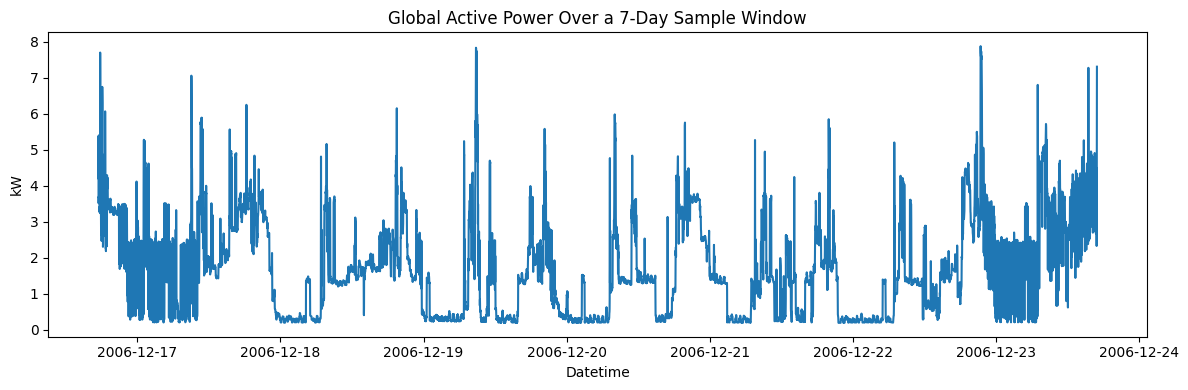

In [88]:
start_date = hourly.index.min()
end_date = start_date + pd.Timedelta(days=7)
mask = (data.index >= start_date) & (data.index < end_date)

plt.figure(figsize=(12, 4))
plt.plot(data.index[mask], data.loc[mask, "Global_active_power"])
plt.title("Global Active Power Over a 7-Day Sample Window")
plt.xlabel("Datetime")
plt.ylabel("kW")
plt.tight_layout()
plt.show()


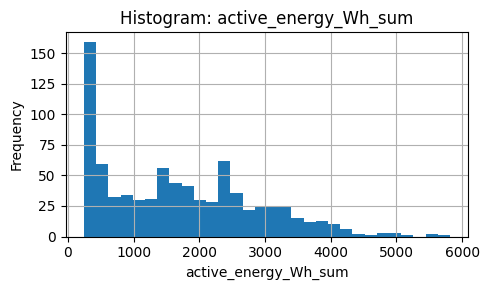

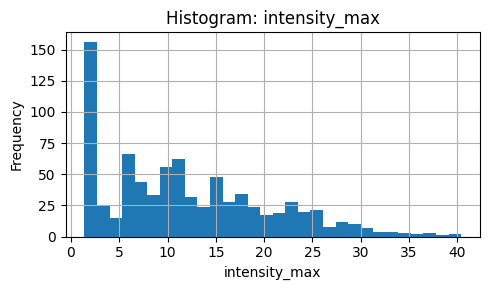

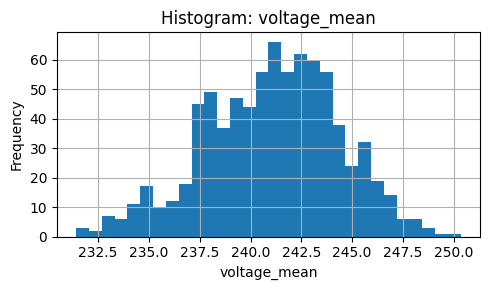

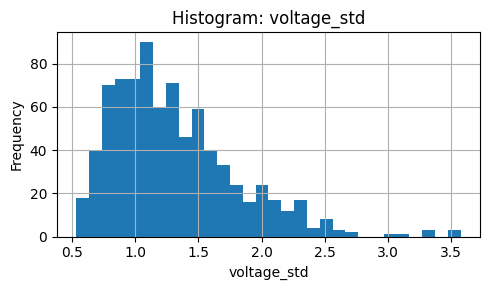

In [89]:
features_to_plot = ["active_energy_Wh_sum", "intensity_max", "voltage_mean", "voltage_std"]
for col in features_to_plot:
    plt.figure(figsize=(5, 3))
    hourly[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


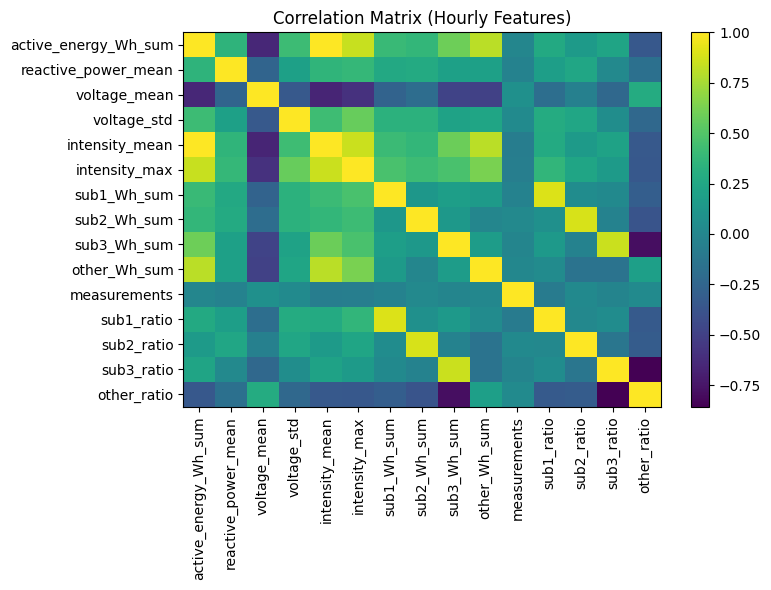

In [90]:
corr = hourly.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (Hourly Features)")
plt.colorbar()
plt.tight_layout()
plt.show()


## 5. Baseline Model: K-Means (No Dimensionality Reduction)

The number of cluster `k` is selected based on various indices


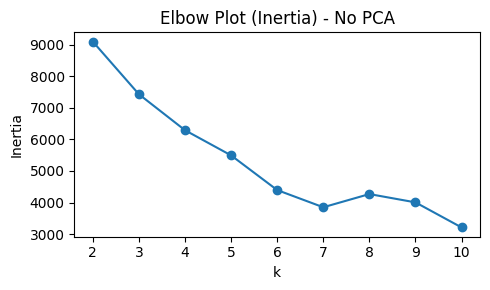

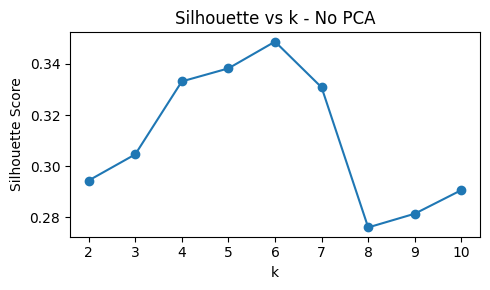

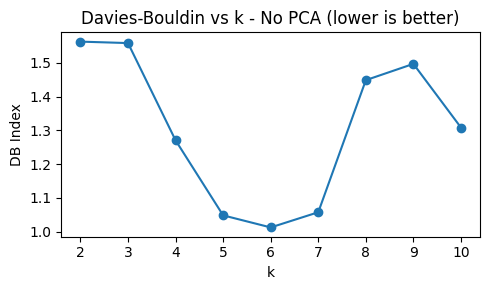

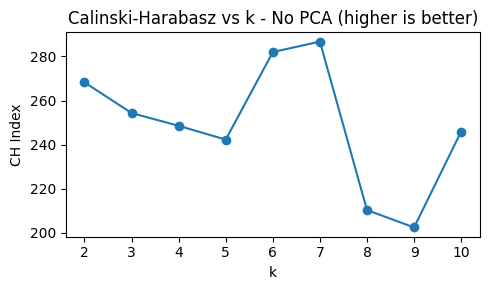

In [91]:
feature_cols = [
    "active_energy_Wh_sum", "reactive_power_mean", "voltage_mean", "voltage_std",
    "intensity_mean", "intensity_max",
    "sub1_Wh_sum", "sub2_Wh_sum", "sub3_Wh_sum", "other_Wh_sum",
    "sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio",
    "measurements",
]
X = hourly[feature_cols].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

ks = list(range(2, 11))
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(Xs)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(Xs, labels))
    db_scores.append(davies_bouldin_score(Xs, labels))
    ch_scores.append(calinski_harabasz_score(Xs, labels))

plt.figure(figsize=(5,3))
plt.plot(ks, inertias, marker="o")
plt.title("Elbow Plot (Inertia) - No PCA")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, sil_scores, marker="o")
plt.title("Silhouette vs k - No PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, db_scores, marker="o")
plt.title("Davies-Bouldin vs k - No PCA (lower is better)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, ch_scores, marker="o")
plt.title("Calinski-Harabasz vs k - No PCA (higher is better)")
plt.xlabel("k")
plt.ylabel("CH Index")
plt.tight_layout()
plt.show()


In [92]:
best_k_no_pca = 6
km_no_pca = KMeans(n_clusters=best_k_no_pca, n_init="auto", random_state=42)
labels_no_pca = km_no_pca.fit_predict(Xs)

hourly_no_pca = hourly.copy()
hourly_no_pca["cluster"] = labels_no_pca

summary_no_pca = hourly_no_pca.groupby("cluster").agg(
    days=("cluster", "size"),
    energy_Wh=("active_energy_Wh_sum", "mean"),
    intensity_max=("intensity_max", "mean"),
    voltage_mean=("voltage_mean", "mean"),
    sub1_ratio=("sub1_ratio", "mean"),
    sub2_ratio=("sub2_ratio", "mean"),
    sub3_ratio=("sub3_ratio", "mean"),
    other_ratio=("other_ratio", "mean"),
).sort_index()

summary_no_pca.round(2)

,days,energy_Wh,intensity_max,voltage_mean,sub1_ratio,sub2_ratio,sub3_ratio,other_ratio
cluster,,,,,,,,
0,49,3076.87,23.79,239.12,0.04,0.47,0.17,0.32
1,301,568.98,5.34,243.41,0.00,0.04,0.02,0.93
2,64,2920.09,22.89,238.97,0.25,0.03,0.27,0.45
3,173,1543.66,9.89,241.02,0.00,0.02,0.61,0.37
4,2,1887.03,24.20,235.83,0.14,0.00,0.31,0.54
5,219,2670.55,17.31,238.94,0.00,0.02,0.18,0.80


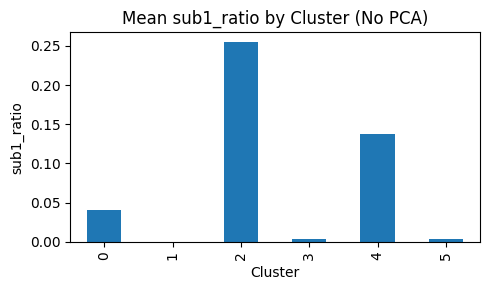

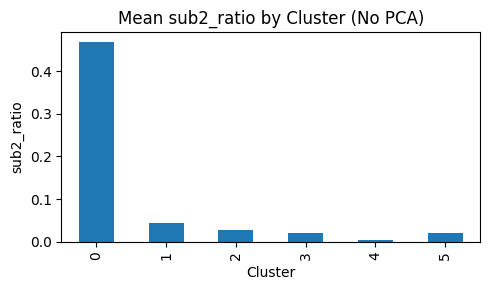

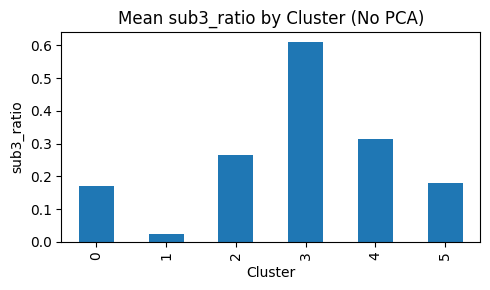

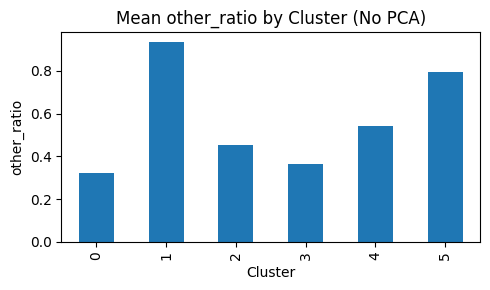

In [93]:
ratio_cols = ["sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio"]
means = hourly_no_pca.groupby("cluster")[ratio_cols].mean()

for col in ratio_cols:
    plt.figure(figsize=(5,3))
    means[col].plot(kind="bar")
    plt.title(f"Mean {col} by Cluster (No PCA)")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## 6. Model with Dimensionality Reduction: PCA + K-Means

We keep enough components to explain **95%** of the variance, then cluster in the reduced space.

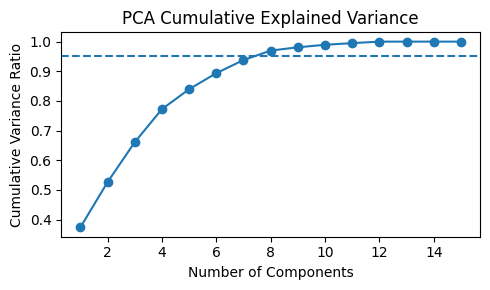

Original features: 15
PCA components kept: 8
Explained variance per component: [0.37342303 0.15238872 0.13481561 0.11146792 0.06741752 0.05402311
 0.0441971  0.03195042]
Cumulative variance: [0.37342303 0.52581174 0.66062736 0.77209527 0.83951279 0.8935359
 0.93773301 0.96968343 0.98088591 0.98930598 0.99493839 0.99995896
 1.         1.         1.        ]


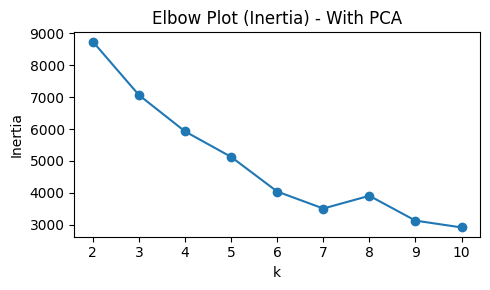

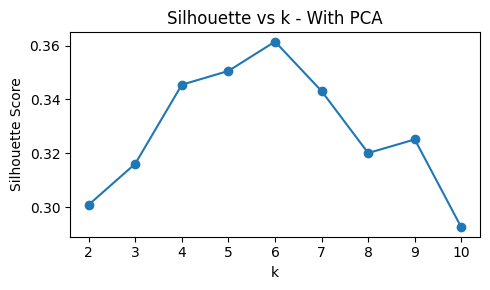

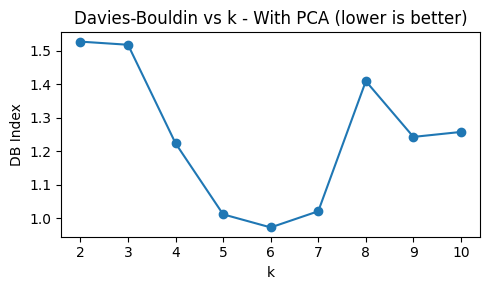

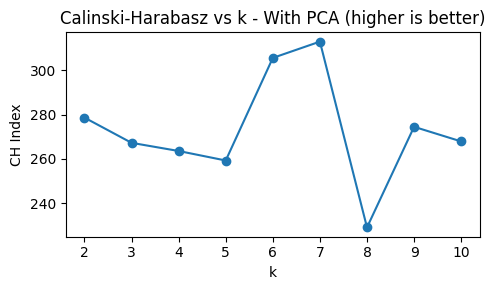

In [94]:
pca_full = PCA(svd_solver="full").fit(Xs)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_comp = int(np.searchsorted(cumvar, 0.95) + 1)

plt.figure(figsize=(5,3))
plt.plot(range(1, len(cumvar)+1), cumvar, marker="o")
plt.axhline(0.95, linestyle="--")
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.tight_layout()
plt.show()

pca = PCA(n_components=n_comp, svd_solver="full")
Xp = pca.fit_transform(Xs)

print("Original features:", Xs.shape[1])
print("PCA components kept:", Xp.shape[1])
print("Explained variance per component:", pca.explained_variance_ratio_)
print("Cumulative variance:", cumvar)


ks = list(range(2, 11))
inertias_pca = []
sil_scores_pca = []
db_scores_pca = []
ch_scores_pca = []

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(Xp)
    inertias_pca.append(km.inertia_)
    sil_scores_pca.append(silhouette_score(Xp, labels))
    db_scores_pca.append(davies_bouldin_score(Xp, labels))
    ch_scores_pca.append(calinski_harabasz_score(Xp, labels))

plt.figure(figsize=(5,3))
plt.plot(ks, inertias_pca, marker="o")
plt.title("Elbow Plot (Inertia) - With PCA")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, sil_scores_pca, marker="o")
plt.title("Silhouette vs k - With PCA")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, db_scores_pca, marker="o")
plt.title("Davies-Bouldin vs k - With PCA (lower is better)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(ks, ch_scores_pca, marker="o")
plt.title("Calinski-Harabasz vs k - With PCA (higher is better)")
plt.xlabel("k")
plt.ylabel("CH Index")
plt.tight_layout()
plt.show()

In [95]:
best_k_pca=6
km_pca = KMeans(n_clusters=best_k_pca, n_init="auto", random_state=42)
labels_pca = km_pca.fit_predict(Xp)

hourly_pca = hourly.copy()
hourly_pca["cluster"] = labels_pca

summary_pca = hourly_pca.groupby("cluster").agg(
    days=("cluster", "size"),
    energy_Wh=("active_energy_Wh_sum", "mean"),
    intensity_max=("intensity_max", "mean"),
    voltage_mean=("voltage_mean", "mean"),
    sub1_ratio=("sub1_ratio", "mean"),
    sub2_ratio=("sub2_ratio", "mean"),
    sub3_ratio=("sub3_ratio", "mean"),
    other_ratio=("other_ratio", "mean"),
).sort_index()

print({"pca_components": n_comp, "n_clusters": 6})
summary_pca.round(2)


{'pca_components': 8, 'n_clusters': 6}


,days,energy_Wh,intensity_max,voltage_mean,sub1_ratio,sub2_ratio,sub3_ratio,other_ratio
cluster,,,,,,,,
0,223,2677.07,17.27,238.89,0.00,0.02,0.19,0.79
1,305,579.49,5.42,243.37,0.00,0.04,0.02,0.93
2,63,2916.92,22.93,238.93,0.26,0.03,0.27,0.45
3,49,3076.87,23.79,239.12,0.04,0.47,0.17,0.32
4,2,1887.03,24.20,235.83,0.14,0.00,0.31,0.54
5,166,1521.43,9.79,241.15,0.00,0.02,0.62,0.36


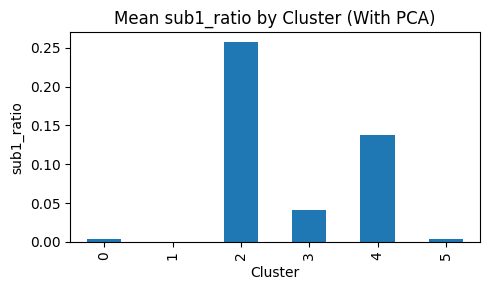

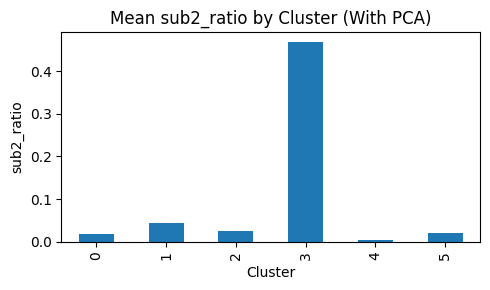

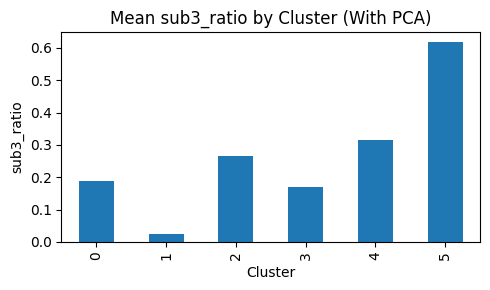

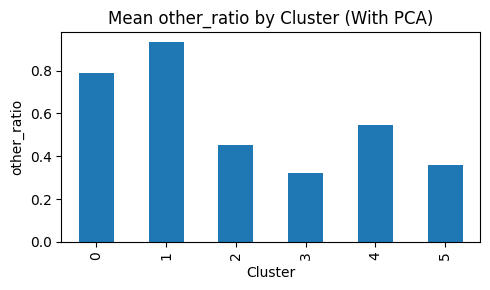

In [96]:
ratio_cols = ["sub1_ratio", "sub2_ratio", "sub3_ratio", "other_ratio"]
means_pca = hourly_pca.groupby("cluster")[ratio_cols].mean()

for col in ratio_cols:
    plt.figure(figsize=(5,3))
    means_pca[col].plot(kind="bar")
    plt.title(f"Mean {col} by Cluster (With PCA)")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## 7. Evaluation & Comparison

Comparing the selected `k` for both pipelines using multiple indices: **Silhouette**, **Davies–Bouldin**, and **Calinski–Harabasz**.

In [97]:
def evaluate_pipeline(X_embedded: np.ndarray, labels: np.ndarray) -> dict[str, float]:
    return {
        "silhouette": float(silhouette_score(X_embedded, labels)),
        "davies_bouldin": float(davies_bouldin_score(X_embedded, labels)),
        "calinski_harabasz": float(calinski_harabasz_score(X_embedded, labels)),
    }

k_no_pca = 6
k_pca    = 6

metrics_no_pca = evaluate_pipeline(Xs, labels_no_pca)
metrics_pca    = evaluate_pipeline(Xp, labels_pca)

print(f"Chosen k (No PCA): {k_no_pca}  |  {metrics_no_pca}")
print(f"Chosen k (With PCA): {k_pca}  |  {metrics_pca}")

comparison = pd.DataFrame(
    [metrics_no_pca, metrics_pca],
    index=[f"No PCA (k={k_no_pca})", f"With PCA (k={k_pca})"]
)
comparison.round(4)

Chosen k (No PCA): 6  |  {'silhouette': 0.3487553577490251, 'davies_bouldin': 1.012568681039823, 'calinski_harabasz': 282.00499634872074}
Chosen k (With PCA): 6  |  {'silhouette': 0.3614639377858955, 'davies_bouldin': 0.9721259182199044, 'calinski_harabasz': 305.66058751708334}


,silhouette,davies_bouldin,calinski_harabasz
No PCA (k=6),0.3488,1.0126,282.0050
With PCA (k=6),0.3615,0.9721,305.6606


Label mapping (PCA -> No-PCA): {0: 5, 1: 1, 2: 2, 3: 0, 4: 4, 5: 3}


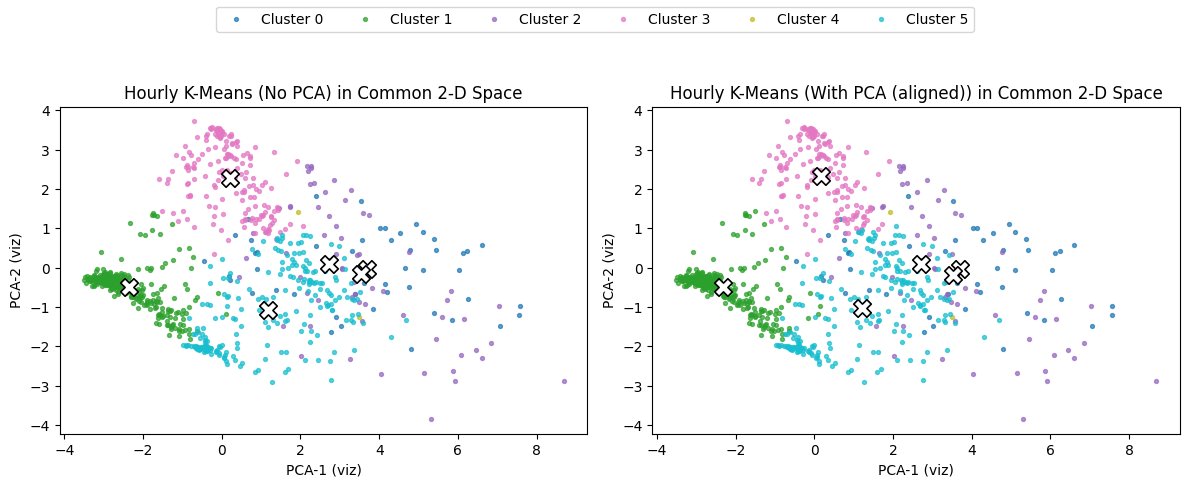

In [98]:
from scipy.optimize import linear_sum_assignment

def _centroids_from_labels(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    ids = np.unique(y)
    return np.vstack([X[y == c].mean(axis=0) for c in ids])

def align_labels_by_centroids(
    X: np.ndarray,
    y_ref: np.ndarray,
    y_to_align: np.ndarray,
) -> tuple[np.ndarray, dict[int, int]]:
    """
    Align y_to_align to y_ref by matching centroids in X (same feature space).
    Returns (y_aligned, mapping dict from old->new).
    """
    ref_ids = np.unique(y_ref)
    ali_ids = np.unique(y_to_align)

    C_ref  = _centroids_from_labels(X, y_ref)
    C_ali  = _centroids_from_labels(X, y_to_align)

    d = np.linalg.norm(C_ali[:, None, :] - C_ref[None, :, :], axis=2)

    if linear_sum_assignment is not None:
        r_idx, c_idx = linear_sum_assignment(d)
        mapping = {int(ali_ids[r]): int(ref_ids[c]) for r, c in zip(r_idx, c_idx)}
    else:
        mapping = {}
        remaining_ali = list(range(len(ali_ids)))
        remaining_ref = list(range(len(ref_ids)))
        d_copy = d.copy()
        while remaining_ali and remaining_ref:
            i, j = np.unravel_index(np.argmin(d_copy), d_copy.shape)
            mapping[int(ali_ids[i])] = int(ref_ids[j])
            d_copy[i, :] = np.inf
            d_copy[:, j] = np.inf
            remaining_ali.remove(i)
            remaining_ref.remove(j)

    y_aligned = np.array([mapping[int(lbl)] for lbl in y_to_align], dtype=int)
    return y_aligned, mapping

labels_pca_aligned, mapping = align_labels_by_centroids(Xs, labels_no_pca, labels_pca)
print("Label mapping (PCA -> No-PCA):", mapping)

def plot_side_by_side_consistent(Xs: np.ndarray,
                                 y_left: np.ndarray,
                                 y_right: np.ndarray,
                                 title_suffix: str = "Hourly") -> None:
    viz_pca = PCA(n_components=2, svd_solver="full").fit(Xs)
    Z2 = viz_pca.transform(Xs)

    all_ids = sorted(np.unique(np.concatenate([y_left, y_right])))
    cmap = plt.colormaps.get_cmap("tab10").resampled(len(all_ids))

    color_map = {cid: cmap(i) for i, cid in enumerate(all_ids)}

    def _centroids(X, y):
        return np.vstack([X[y == c].mean(axis=0) for c in all_ids])

    C_left_2d  = viz_pca.transform(_centroids(Xs, y_left))
    C_right_2d = viz_pca.transform(_centroids(Xs, y_right))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), squeeze=False)
    for ax, y, cents2d, name in [
        (axes[0,0], y_left,  C_left_2d,  "No PCA"),
        (axes[0,1], y_right, C_right_2d, "With PCA (aligned)"),
    ]:
        for cid in all_ids:
            m = (y == cid)
            ax.scatter(Z2[m,0], Z2[m,1], s=8, alpha=0.7, color=color_map[cid], label=f"Cluster {cid}")
        ax.scatter(cents2d[:,0], cents2d[:,1], s=160, marker="X", edgecolor="black",
                   facecolor="white", linewidths=1.2)
        ax.set_title(f"{title_suffix} K-Means ({name}) in Common 2-D Space")
        ax.set_xlabel("PCA-1 (viz)"); ax.set_ylabel("PCA-2 (viz)")
        ax.set_aspect("equal")

    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=min(6, len(all_ids)))
    plt.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

plot_side_by_side_consistent(Xs, labels_no_pca, labels_pca_aligned, title_suffix="Hourly")
